In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from nilearn._utils import check_niimg
from nilearn.image import iter_img
from nilearn.input_data import NiftiMasker
from cogspaces.datasets.dictionaries import fetch_atlas_modl
from cogspaces.datasets.utils import fetch_mask, get_output_dir
from sklearn.preprocessing import StandardScaler

from os.path import expanduser


modl_atlas = fetch_atlas_modl()
dictionary_img = check_niimg(modl_atlas['components512'])
mask = fetch_mask()['hcp']
masker = NiftiMasker(mask_img=mask).fit()
dictionary = masker.transform(dictionary_img)

In [4]:
coefs = np.load('all_coefs.npy')

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128)
pca = pca.fit(coefs)


In [6]:
np.sum(pca.explained_variance_ratio_)

0.93420875

In [7]:
# coefs = pca.inverse_transform(pca.transform(coefs))

In [8]:
pca_components = pca.components_

In [9]:
np.save(expanduser('~/work/repos/cogspaces/exps/gamble_svd'), pca_components)

In [10]:
from modl.decomposition.dict_fact import DictFact
from os.path import expanduser

In [11]:
import time

class DictionaryScorer:
    def __init__(self, test_data, info=None):
        self.start_time = time.clock()
        self.test_data = test_data
        self.test_time = 0
        self.time = []
        self.cpu_time = []
        self.score = []
        self.iter = []
        self.density = []
        self.exp_var = []
        
    def __call__(self, dict_fact):
        test_time = time.clock()
        score = dict_fact.score(self.test_data)
        
        alpha = df.transform(self.test_data)
        residuals = self.test_data - alpha.dot(dict_fact.components_)
        exp_var = np.mean(1 - np.sum(residuals ** 2, axis=1) / np.sum(self.test_data ** 2, axis=1))
        
        self.exp_var.append(exp_var)
        
        self.test_time += time.clock() - test_time
        this_time = time.clock() - self.start_time - self.test_time
        self.time.append(this_time)
        self.score.append(score)
        self.iter.append(dict_fact.n_iter_)
        self.cpu_time.append(dict_fact.time_)
        self.density.append((dict_fact.components_ != 0).mean())

In [200]:
from sklearn.utils import check_random_state
import math
sc = StandardScaler(with_std=False, with_mean=True)
sc.fit(coefs)
coefs = sc.transform(coefs)

random_state = check_random_state(0)
dict_init = random_state.randn(128, 512) / math.sqrt(512)

assign = np.load(expanduser('~/work/repos/cogspaces/exps/assign.npy'))

# dict_init = np.load(expanduser('/home/arthur/work/repos/cogspaces/exps/loadings_128.npy'))[0].T

# random_state = check_random_state(0)
# indices = random_state.permutation(len(coefs))[:128]
# dict_init = coefs[indices]

dict_init += dict_init[:, assign]
dict_init /= 2

cb = DictionaryScorer(coefs[:128])

dict_init_proj = pca.inverse_transform(pca.transform(dict_init))
coefs_proj = pca.inverse_transform(pca.transform(coefs))
# dict_init_proj = dict_init
np.save(expanduser('~/work/repos/cogspaces/exps/dict_init_proj.npy'), dict_init_proj)
np.save(expanduser('~/work/repos/cogspaces/exps/dict_init_not_proj.npy'), dict_init)

df = DictFact(comp_l1_ratio=1, comp_pos=False, n_components=128, code_l1_ratio=0, batch_size=128,
              dict_init=dict_init,
              code_alpha=5e-4, verbose=10, n_epochs=10, callback=cb)

df.fit(coefs_proj)
# df.fit(coefs)

df.components_ = pca.inverse_transform(pca.transform(df.components_))

Iteration 0
Iteration 256
Iteration 640
Iteration 1536
Iteration 3712
Iteration 8704
Iteration 20224
Iteration 47232
Iteration 109952
Iteration 255872


In [193]:
cb.score, cb.density, cb.exp_var

([3.7120780982971193,
  1.0950076627731322,
  1.0314825048446656,
  1.0091228189468384,
  0.998118272304535,
  0.9899361252784729,
  0.9830138592720032,
  0.976836856842041,
  0.9715162839889526,
  0.9667821950912476],
 [1.0,
  0.7598419189453125,
  0.7423095703125,
  0.719696044921875,
  0.71661376953125,
  0.716400146484375,
  0.7140045166015625,
  0.7095184326171875,
  0.704071044921875,
  0.6996917724609375],
 [0.53863037,
  0.90511644,
  0.9137349,
  0.9171072,
  0.9188648,
  0.92001384,
  0.92075384,
  0.9212935,
  0.9216591,
  0.9219272])

In [194]:
density = (df.components_ != 0).mean()
print('Density:', density)

Density: 1.0


In [195]:
alpha = df.transform(coefs)
print((alpha == 0).mean())
components = df.components_

residuals = coefs - alpha.dot(components)
exp_var = np.mean(1 - np.sum(residuals ** 2, axis=1) / np.sum(coefs ** 2, axis=1))
exp_var

0.0


0.92552346

In [196]:
exp_var = []
for i in range(len(components)):
    residuals = coefs - alpha[:, i][:, None] * components[i, :][None, :]
    this_exp_var = 1 - np.mean(np.sum(residuals ** 2, axis=1) / np.sum(coefs ** 2, axis=1))
    exp_var.append(this_exp_var)
exp_var = np.array(exp_var)
sort = np.argsort(exp_var)[::-1]
exp_var = exp_var[sort]
alpha = alpha[:, sort]
components = components[sort, :]
dict_init = dict_init[sort]
print(exp_var)

[0.01180959 0.01163936 0.01119089 0.01118445 0.01111579 0.01064903
 0.01064664 0.01063395 0.01058352 0.01036119 0.01034439 0.01032805
 0.01030654 0.01029366 0.01027876 0.0102272  0.01008254 0.00993228
 0.00975943 0.00975347 0.00973785 0.00972122 0.00968093 0.00956172
 0.00955373 0.00952584 0.00952411 0.00951326 0.00945127 0.00938725
 0.00934637 0.00932831 0.00932151 0.00931746 0.00926352 0.00924623
 0.00917226 0.00912797 0.0091064  0.00908256 0.00905436 0.00900221
 0.00899363 0.00899178 0.0089252  0.00891984 0.00891662 0.00890899
 0.00888717 0.00887454 0.00886315 0.00884748 0.00882393 0.00882196
 0.00881958 0.00879961 0.00879645 0.00877678 0.00875968 0.00874954
 0.00872552 0.0087207  0.0087105  0.00870305 0.00869584 0.00867629
 0.00867361 0.00866675 0.00865996 0.00865829 0.00864655 0.00862753
 0.00862747 0.00862235 0.00861859 0.00861055 0.00860405 0.00860274
 0.00856239 0.00855362 0.008551   0.00849402 0.00846237 0.00845629
 0.00845575 0.00842404 0.00830728 0.00829488 0.00822532 0.0082

In [197]:
dict_init_ = dict_init / np.sqrt(np.sum(dict_init ** 2, axis=1, keepdims=True))
components_ = components / np.sqrt(np.sum(components ** 2, axis=1, keepdims=True))

corr = components_.dot(dict_init_.T)
from sklearn.utils.linear_assignment_ import linear_assignment
assign = linear_assignment(-corr)[:, 1]
corr = corr[:, assign]
print(np.mean(np.diag(corr)))
dict_init = dict_init[assign]

0.6285661


In [198]:
maps = components.dot(dictionary)
maps_init = dict_init.dot(dictionary)

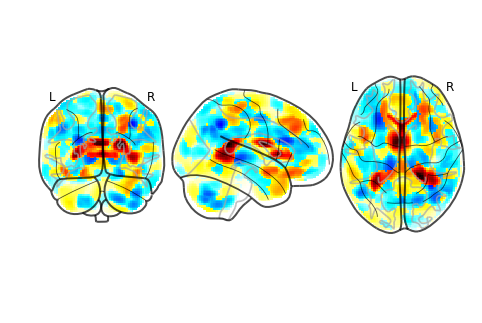

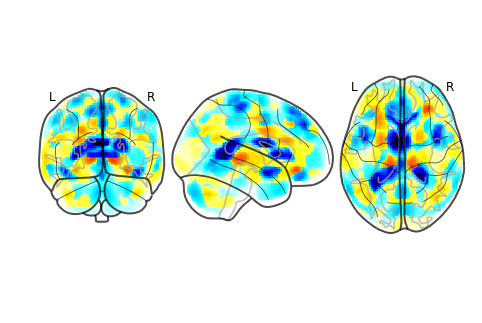

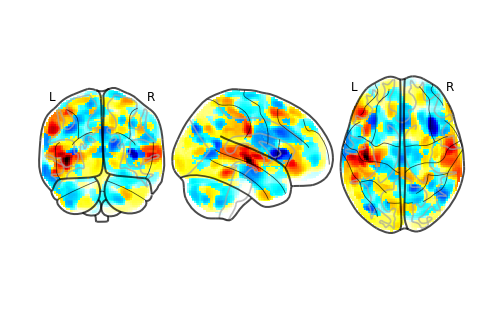

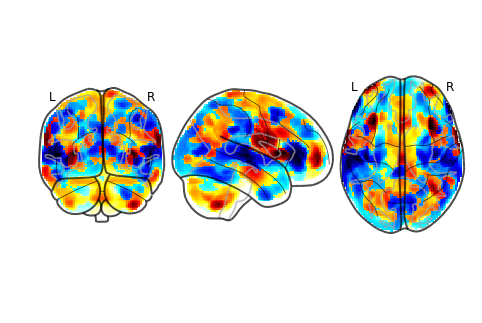

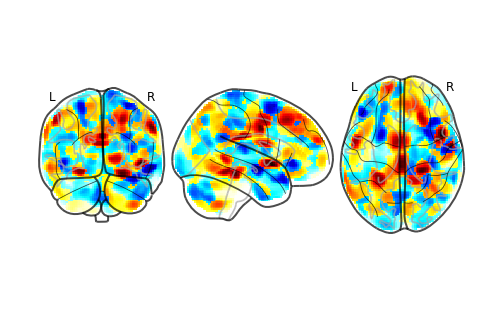

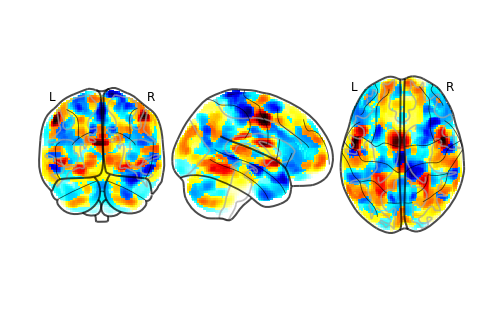

In [199]:
from nilearn.plotting import plot_glass_brain, find_xyz_cut_coords

for i in range(3):
    this_comp = maps[i]
    this_comp_init = maps_init[i]
    if this_comp.max() + this_comp.min() < 0:
        this_comp = - this_comp
    img = masker.inverse_transform(this_comp)
    vmax = np.abs(this_comp).max()
    cut_coords = find_xyz_cut_coords(img, activation_threshold=vmax / 3)
    fig = plt.figure()
    plot_glass_brain(masker.inverse_transform(this_comp), cut_coords=cut_coords, threshold=0,plot_abs=False, figure=fig)
#     plt.savefig(expanduser('~/factored+dl+refine/components_%i.png' % i))
#     plt.close(fig)
    fig = plt.figure()
    plot_glass_brain(masker.inverse_transform(this_comp_init), cut_coords=cut_coords, threshold=0,plot_abs=False, figure=fig)

0.47263998


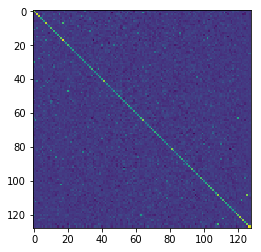

In [179]:
dict_init_ = dict_init / np.sqrt(np.sum(dict_init ** 2, axis=1, keepdims=True))
components_ = components / np.sqrt(np.sum(components ** 2, axis=1, keepdims=True))

corr = dict_init_.dot(components_.T)
from sklearn.utils.linear_assignment_ import linear_assignment
assign = linear_assignment(-corr)[:, 1]
corr = corr[:, assign]
plt.imshow(corr)
print(np.mean(np.diag(corr)))

In [ ]:
components.shape

In [189]:
np.save(expanduser('~/work/repos/cogspaces/exps/gamble_proj_dict'), components)

In [191]:
df.components_ = pca.inverse_transform(pca.transform(df.components_))
np.save(expanduser('~/work/repos/cogspaces/exps/gamble_proj_dict_proj'), df.components_)